In [1595]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelmin
import pandas as pd
from collections import Counter
import os

from pathlib import Path

from scipy import signal
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import signal

import pickle 

from sklearn.neighbors import KNeighborsRegressor



In [1596]:
#auscultatory_sbp = []
#auscultatory_pressure = []
everything = {}

path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"

participants_data =  path_aurora_dataset / "participants.tsv"

basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

In [1597]:

def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    #return data[abs(data - np.mean(data)) < 0.3 * np.mean(data)]
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    # juts deleted stuff from both lists if its in tht 40 range 
    # THIS IS THE MOST IMPORTANT 
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))
    print("diffrences ", min_peaks, diffrences_new_min)

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    print("YO ",diffrences_new_min)
    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):
                # overlapped_means[f"pulse {i}"] = list(y_rotated)[:int(mean_new_min)]

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                #overlapped_means[f"pulse {i}"] = list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)])
                #  gave error: https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)
    # WORKS STAY LIKE TAHTA^^^^  MAKES THE MEAN THE HIGHEST VLAUE , 
    #maybe later make it wider but for now it would work the same!
    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    # print(all_overlaps_means)
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y


def get_person_activity_data(person_id):
    filler_to_person = basic_mesures_data[basic_mesures_data["pid"] == person_id]
    

    for each_path in filler_to_person["waveform_file_path"]:
        each_path_50_cords = get_50_avg_coordinates(path_aurora_dataset/each_path)
        # auscultatory_pressure.append(each_path_50_cords)
        everything[each_path] = [each_path_50_cords, filler_to_person[filler_to_person["waveform_file_path"] == each_path]["sbp"], 
                                 filler_to_person[filler_to_person["waveform_file_path"] == each_path]["dbp"] ]

        


    #return  filler_to_person["sbp"]


In [771]:
#seeing the bad keys

# for path in bad_keys:
#     #print("/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/"+path)
        
#     print(get_50_avg_coordinates("/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/"+path))

In [715]:
# this will be main loop ---- later.... To run on who data set


# for person in sorted(os.listdir(path_aurora_dataset/"measurements_auscultatory")):
#     if "a" in person:
        
#         get_person_activity_data(person)



In [586]:
# # ^^ to put into pickle
# with open('measurements_auscultatory_dictionary_439_end.pkl', 'wb') as f:
#     pickle.dump(everything, f)

In [1598]:
dictionary_path = "/Users/cslinxs/Desktop/all_weeks/summer24-lab/measurements_auscultatory_dictionary_ALL.pkl"

with open(dictionary_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)

all_auscultatory_dic

{'measurements_auscultatory/a000/a000.initial.Calibration_start_1.tsv': [array([7.17954371e-03, 1.93646506e+00, 1.23415649e+01, 2.93360597e+01,
         4.60464001e+01, 5.90886700e+01, 6.73317379e+01, 7.27743152e+01,
         7.64043699e+01, 7.90445097e+01, 8.07335604e+01, 8.16219769e+01,
         8.13946747e+01, 8.02365232e+01, 7.80159551e+01, 7.47492859e+01,
         6.97354561e+01, 6.28670984e+01, 5.61210393e+01, 5.13485034e+01,
         4.80130149e+01, 4.57749604e+01, 4.43633342e+01, 4.36031827e+01,
         4.28326591e+01, 4.14571639e+01, 3.94022731e+01, 3.66757330e+01,
         3.40201054e+01, 3.16554442e+01, 2.97227746e+01, 2.78786140e+01,
         2.59812100e+01, 2.39396712e+01, 2.18384918e+01, 1.98905176e+01,
         1.80494475e+01, 1.63065076e+01, 1.48229648e+01, 1.34833138e+01,
         1.22016636e+01, 1.08559377e+01, 9.43673614e+00, 7.96441781e+00,
         6.60364208e+00, 5.16707114e+00, 3.84182712e+00, 2.43881947e+00,
         1.36278795e+00, 5.64206192e-01]),
  0    110

In [1599]:
#getting rid of bad keys(might need to go forever bc the graph is too messy


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]

#double checking
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        print("um")

auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [1577]:
# here i want to fillter based on activity!!
data_name = "Calibration_start"#"Static_seated_challenge"#"Exercise_challenge"#"Calibration_start"
auscultatory_pressure= []
auscultatory_sbp  = []

participants_csv_data = pd.read_csv(participants_data,sep = '\t')
participants_csv_data = participants_csv_data[participants_csv_data["self_report_htn"].isin(["managed","unmanaged"])]
participants_csv_data = participants_csv_data[participants_csv_data["pid"].str.contains('a')]
people_htn = participants_csv_data["pid"]


for key, each_grouping in all_auscultatory_dic.items():
    if "Calibration_start" in key :

    #if int(each_grouping[1]) in range(140,160):
    
        auscultatory_pressure.append(each_grouping[0])
        auscultatory_sbp.append(each_grouping[1])

In [1600]:
"a003" in list(people_htn)

True

In [1601]:
group_ppl = {}
for key, each_grouping in list(all_auscultatory_dic.items()):
    person_id = key.split("_")[1].split("/")[1]
    if person_id in list(people_htn):
        if not(person_id in group_ppl):
            group_ppl[person_id] = []
        group_ppl[person_id].append({key: each_grouping})
        for i in each_grouping:
            activty_key = key.split("_")[1].split(".")[2]



In [ ]:
for key in all_auscultatory_dic:
    if (key in group_ppl):


In [1602]:
def get_person_data(PID):
    return ([([each_data[0] for each_data in item.values()]) for item in group_ppl[PID]], [([each_data[1] for each_data in item.values()][0]) for item in group_ppl[PID]], [item.keys() for item in group_ppl[PID]])
get_person_data("a003")[2]

[dict_keys(['measurements_auscultatory/a003/a003.initial.Calibration_start_1.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Calibration_start_2.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Calibration_start_3.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Static_challenge_start_1.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Static_challenge_start_2.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Static_challenge_start_3.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Seated_calibration_1.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Seated_calibration_2.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Seated_calibration_3.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Static_seated_challenge_1.tsv']),
 dict_keys(['measurements_auscultatory/a003/a003.initial.Static_seated_challenge_2.tsv']),
 dict_keys(['measurements_auscultat

In [1522]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

group_activity = {}
for i in keys_for_grouping:
    group_activity[i] = [[],[]]

(0.0, 100.0)

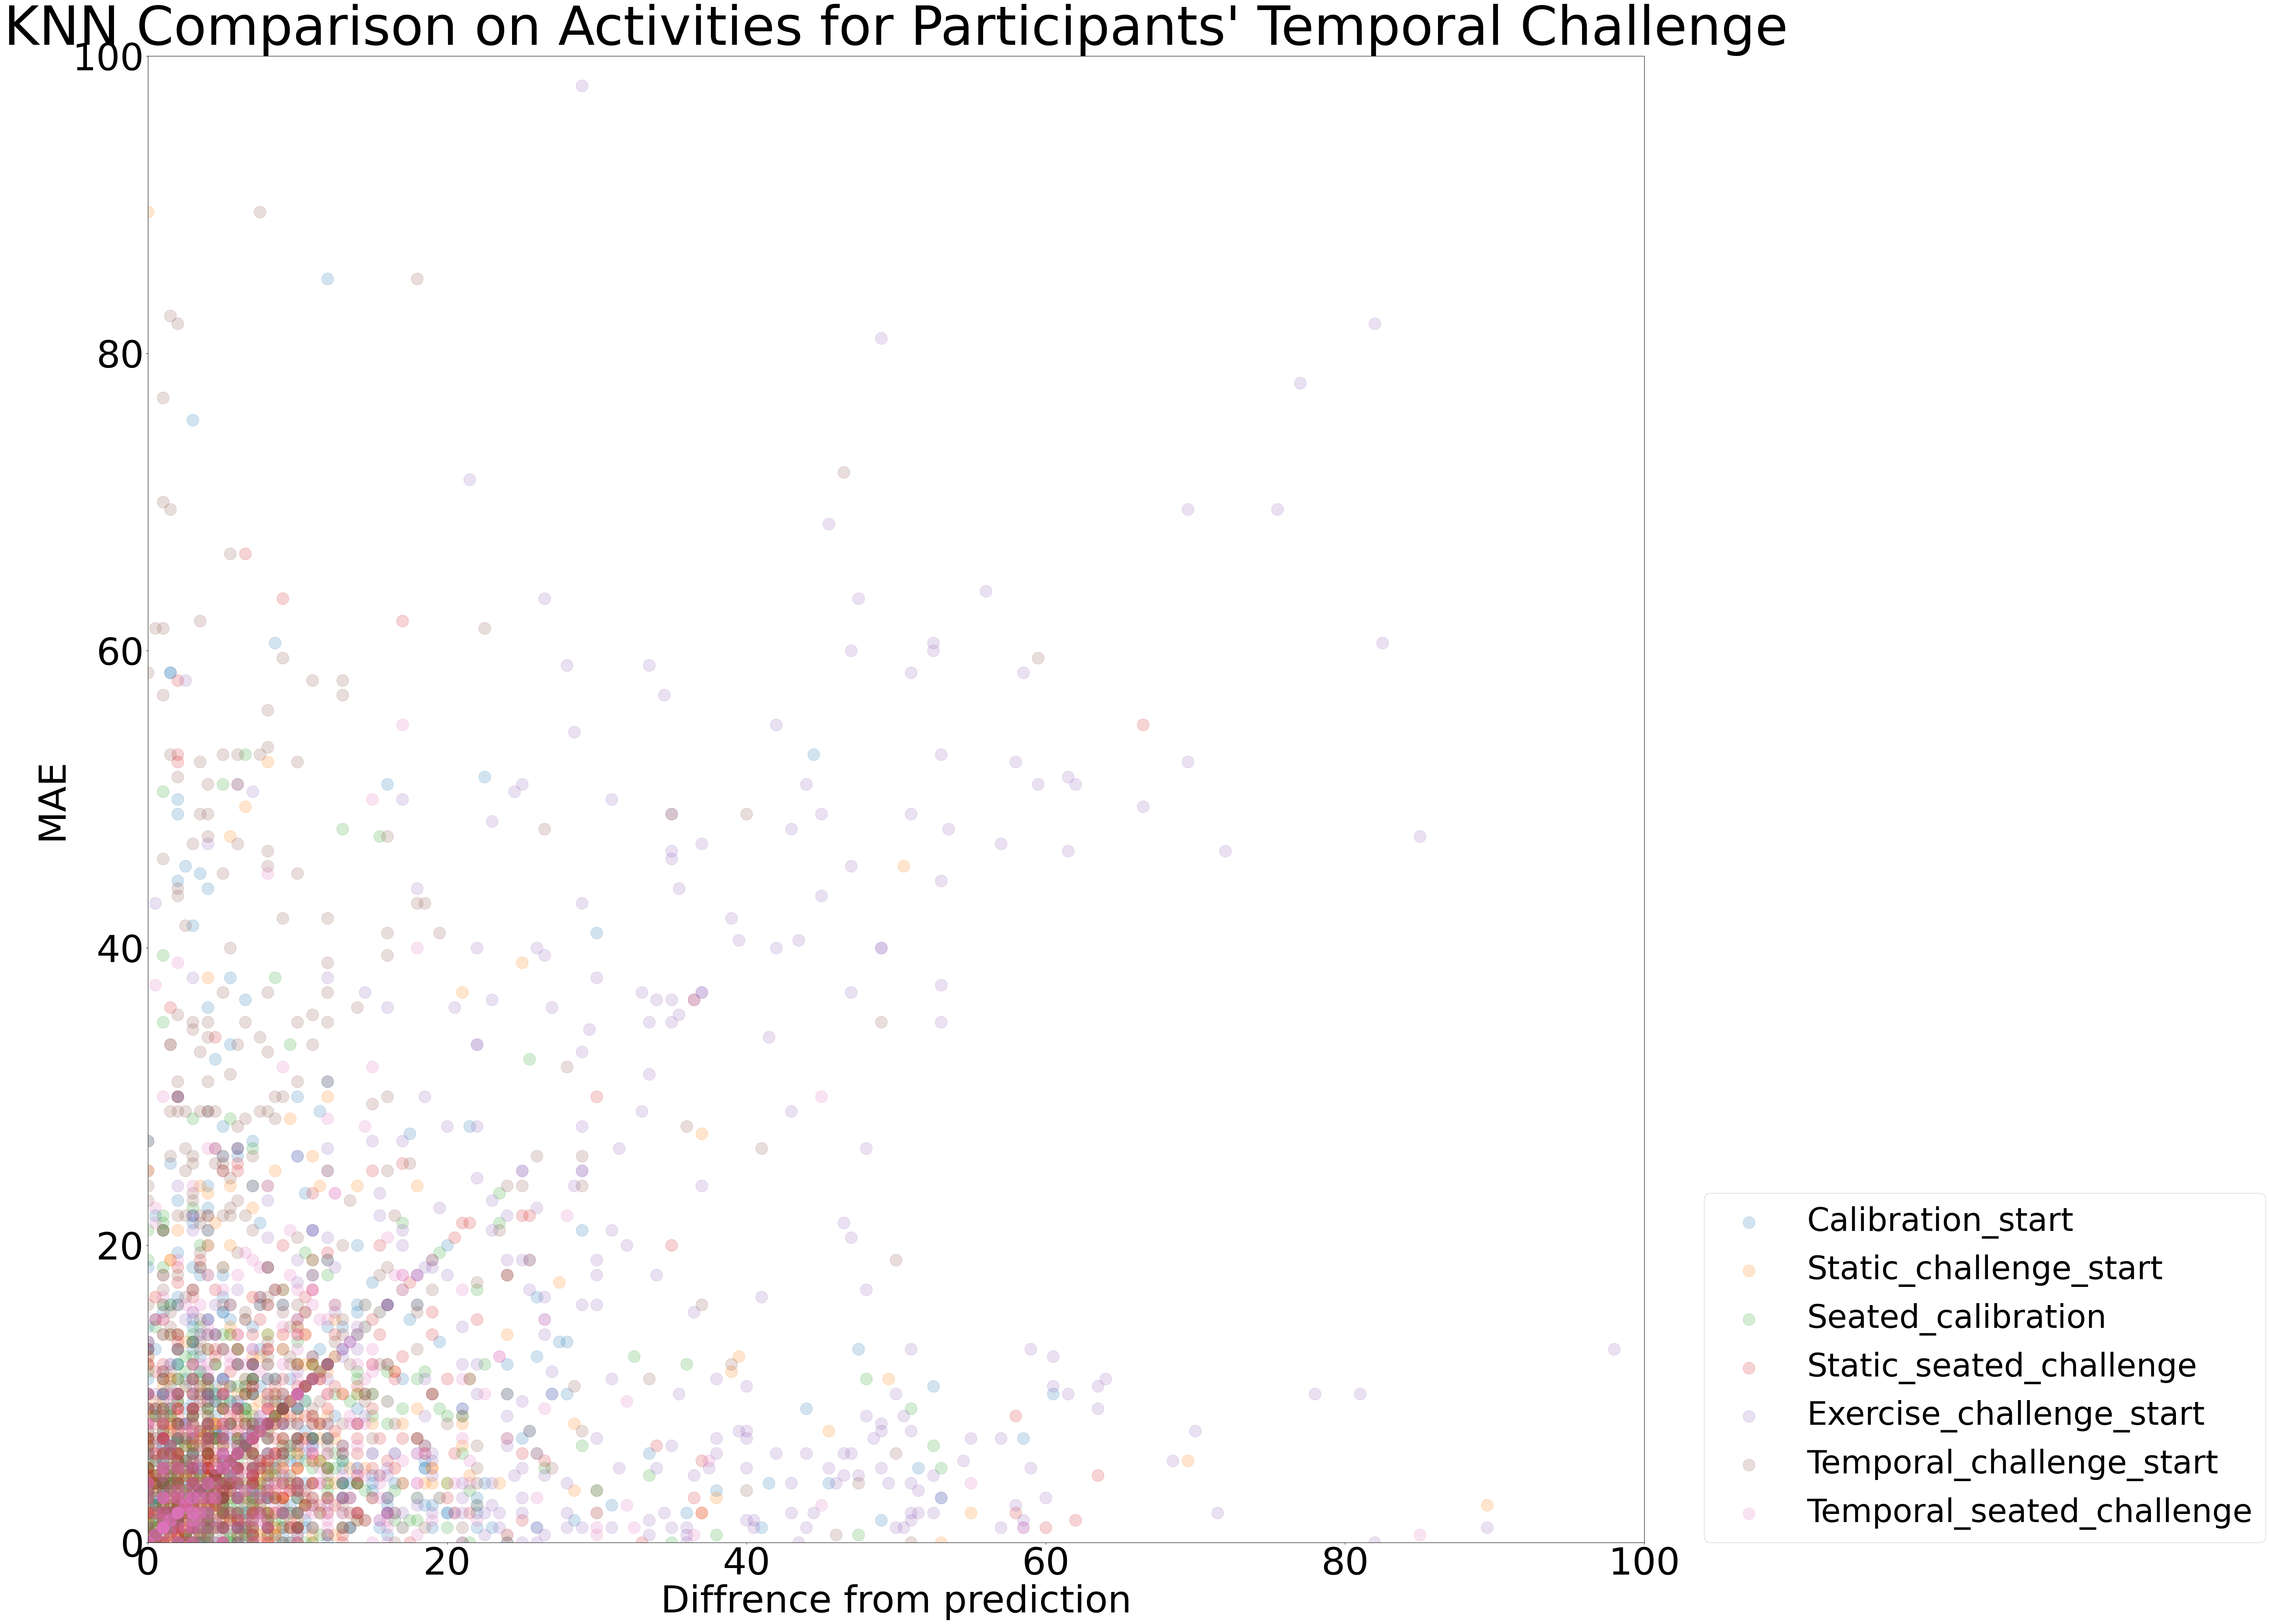

In [1672]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

group_activity = {}
for i in keys_for_grouping:
    group_activity[i] = [[],[]]


neigh = KNeighborsRegressor(n_neighbors=1)

test_start = 0



for person_key_id in list(group_ppl.keys())[:]:
    tester_pid = person_key_id
    
    X = get_person_data(tester_pid)[0]
    Y = get_person_data(tester_pid)[1]
    group_activity_keys = get_person_data(tester_pid)[2]
    for test_start in range(len(X)):
        
        X = get_person_data(tester_pid)[0]
        Y = get_person_data(tester_pid)[1]
        X_test= np.array(X[test_start])
        Y_test= np.array(Y[test_start])

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)




        X_train =  np.array(X[0:test_start]+X[test_start+1:])
        Y_train= Y[0:test_start] +Y[test_start+1:] 

        #print( len(Y[0:test_start]))

        X_train = X_train.reshape(X_train.shape[0], -1)


        the_fit= neigh.fit(X_train, Y_train)

        y_predict= neigh.predict(X_test)
        #print(abs(Y_test- y_predict),MAE, group_activity_keys[test_start])

        for i in keys_for_grouping:
            #print(type(group_activity_keys[test_start]))
            if i in str(group_activity_keys[test_start]):
                group_activity[i][0].append(abs(Y_test- y_predict)[0][0])
                group_activity[i][1].append(MAE)

        MAE = round(root_mean_squared_error(Y_test, y_predict),2,)




plt.figure(figsize=(50, 50)) 


for i,values in  group_activity.items():
   
   plt.scatter(values[0],values[1],  alpha=0.2 , s=500, label=i)
# plt.title(f"KNN tested on '{tester_pid}'s each activity excluding 1")
#lt.scatter(group_activity["Temporal_challenge_start"][0],group_activity[" "][1],  alpha=0.5 , s=500, label="", color="pink")


plt.rcParams.update({'font.size': 70})
plt.legend(loc=(1.04, 0),fontsize=60)
plt.title("KNN Comparison on Activities for Participants' Temporal Challenge", fontdict = {'fontsize' : 100})

plt.xlabel("Diffrence from prediction")
plt.ylabel("MAE")

plt.xlim(0,100)
plt.ylim(0,100)

In [1592]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]
keys_for_grouping

['Calibration_start',
 'Static_challenge_start',
 'Seated_calibration',
 'Static_seated_challenge',
 'Exercise_challenge_start',
 'Temporal_challenge_start',
 'Temporal_seated_challenge']

[np.float64(16.077596286548072), np.float64(17.53718815796674), np.float64(5.605755672396796), np.float64(24.34557014148571), np.float64(20.12224838828311), np.float64(12.453644327815368), np.float64(2.311744233160212), np.float64(0.5366197012804435), np.float64(2.16842267281217), np.float64(15.967313183747322), np.float64(12.716653622490071), np.float64(18.42686587767335), np.float64(10.10756982317011), np.float64(3.162404384182736), np.float64(0.7751938240025567), np.float64(10.188003974705396), np.float64(10.359825154707934), np.float64(2.688037920038326), np.float64(48.417583307256166), np.float64(26.140019683873135), np.float64(96.76713258078354), np.float64(5.578915046359654), np.float64(1.1010323875112817), np.float64(1.6144853488313515), np.float64(20.397384400154436), np.float64(1.1400591306742172), np.float64(3.076563385815035), np.float64(29.953441697365037), np.float64(14.25069263567471), np.float64(14.227898481041422), np.float64(12.409631346943087), np.float64(1.585626396

(0.0, 100.0)

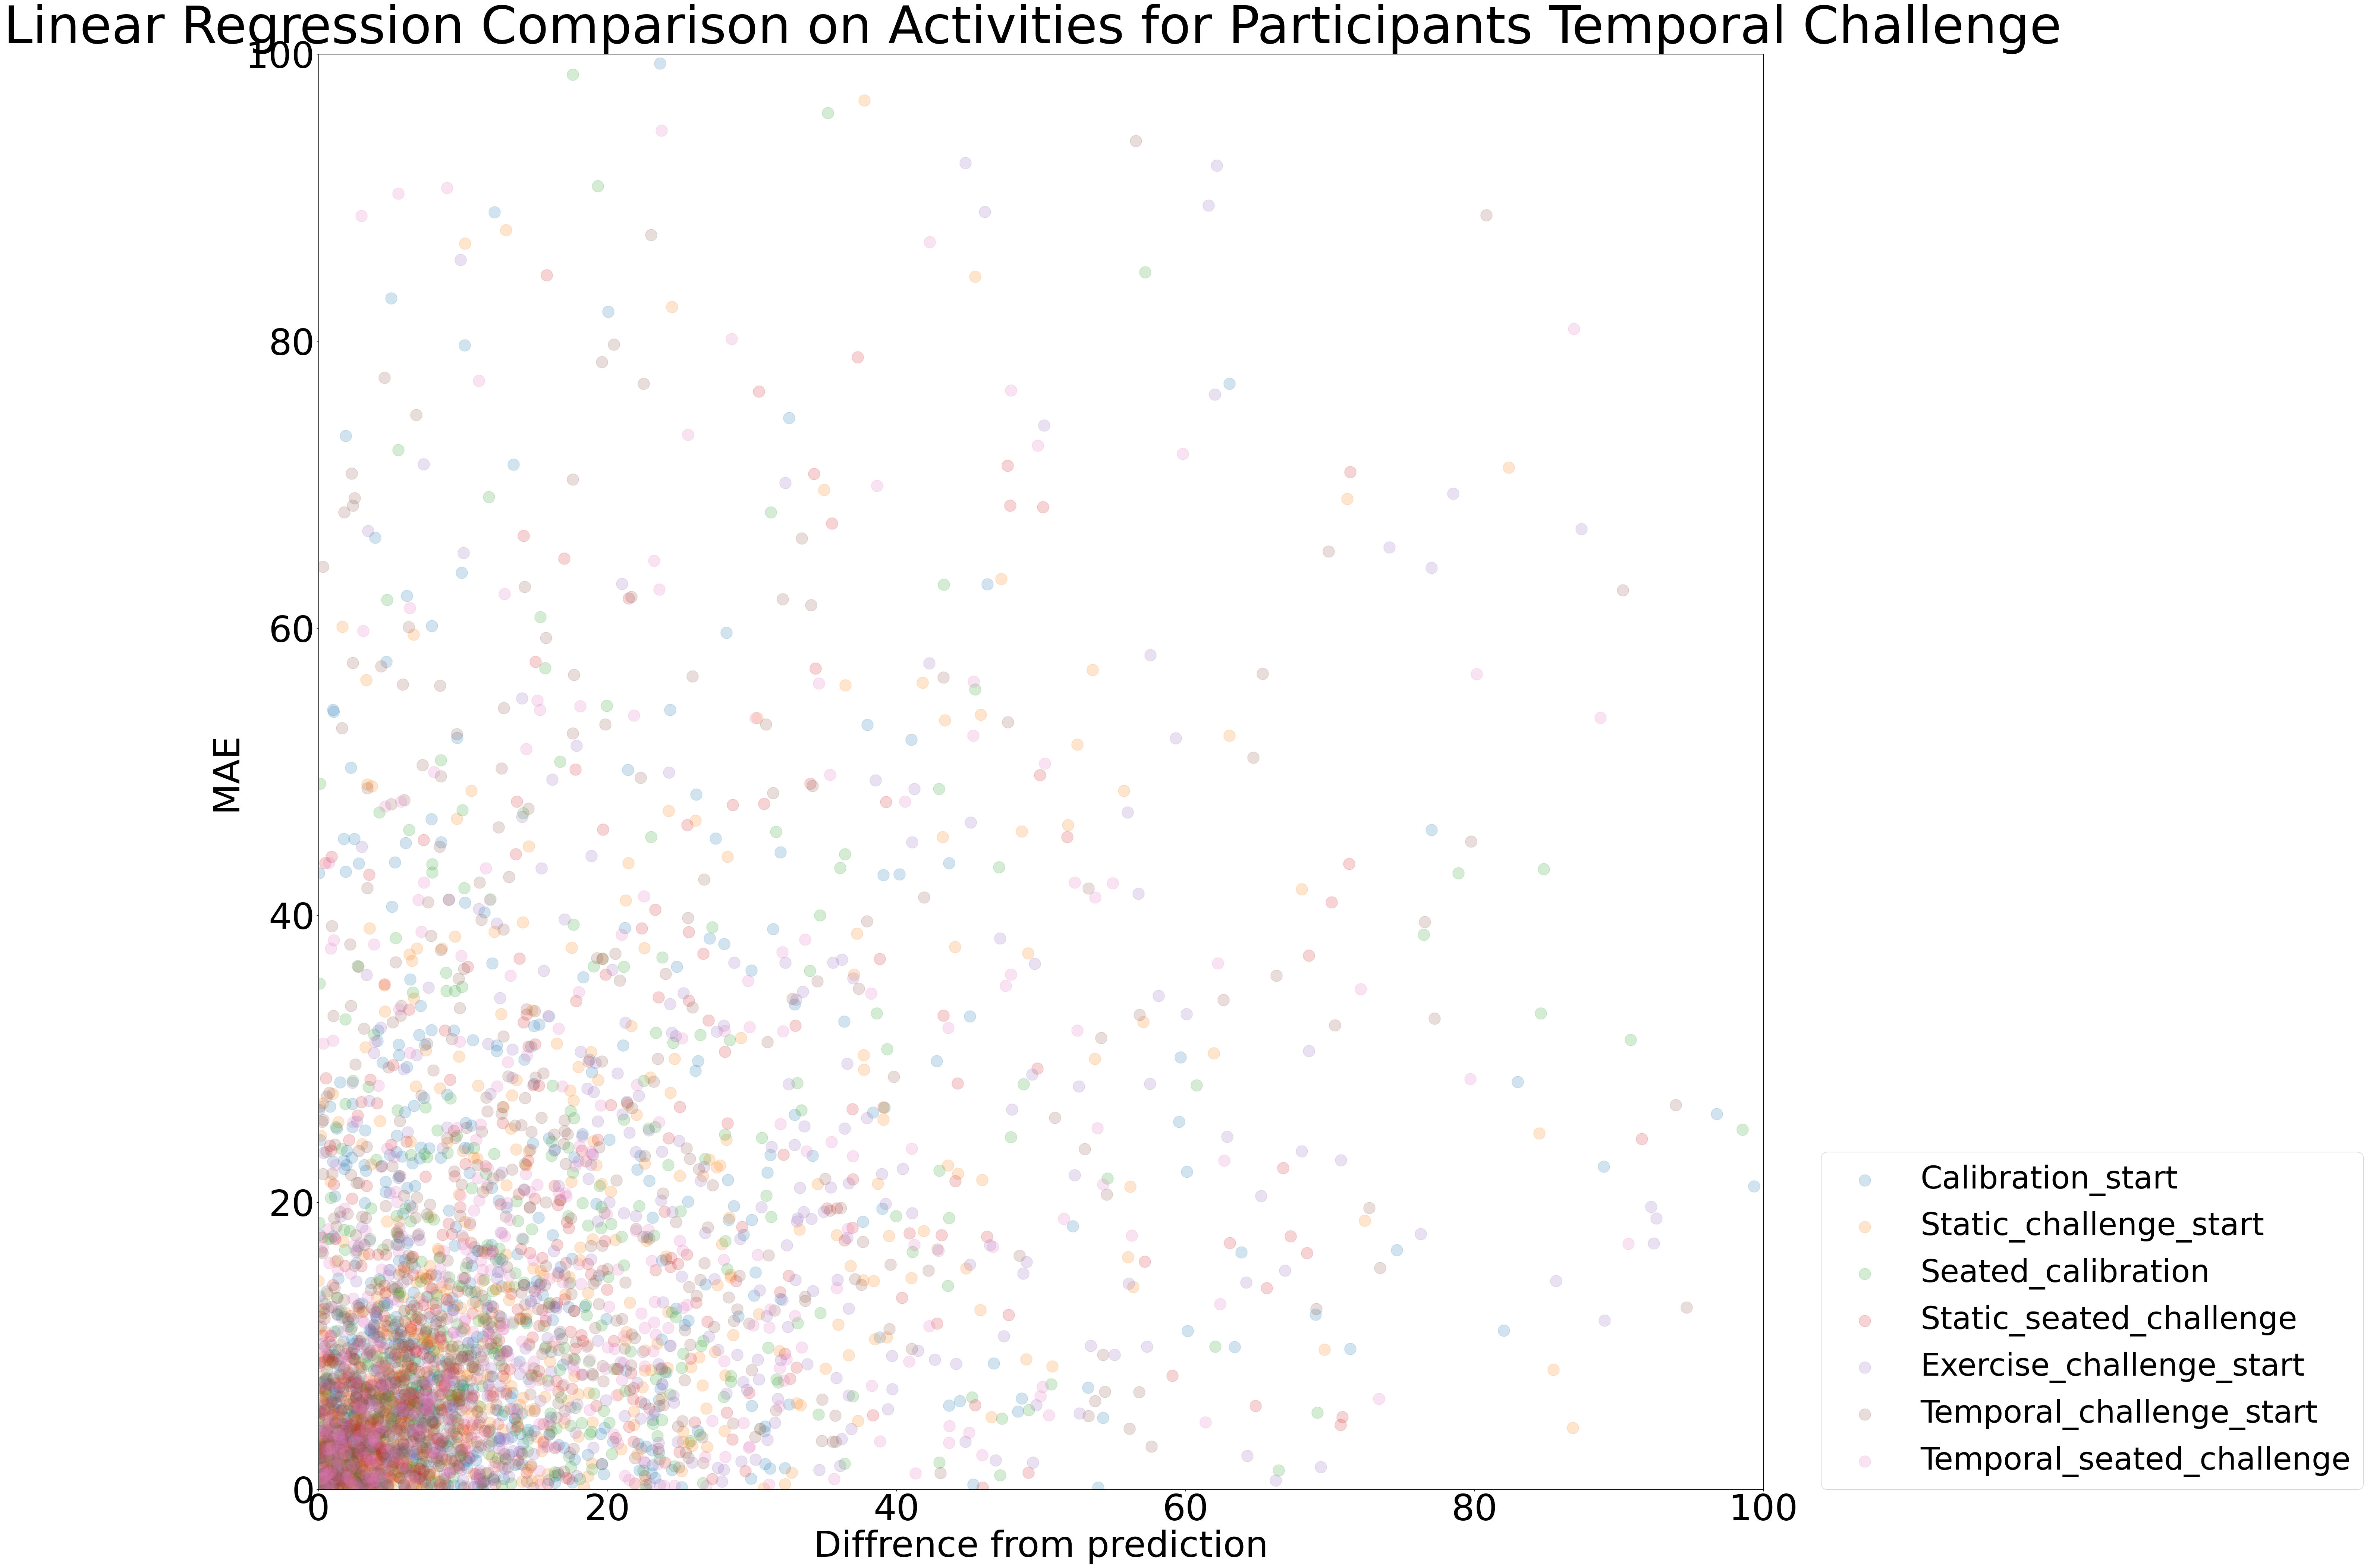

In [1673]:
font = {'size': 70}
 
# using rc function
plt.rc('font', **font)


keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]
#plt.rcParams.update({'font.size': 22})

group_activity = {}
for i in keys_for_grouping:
    group_activity[i] = [[],[]]


neigh = LinearRegression()

test_start = 0
plt.rcParams.update({'font.size': 70})


for person_key_id in list(group_ppl.keys())[:]:
    tester_pid = person_key_id
    
    X = get_person_data(tester_pid)[0]
    Y = get_person_data(tester_pid)[1]
    group_activity_keys = get_person_data(tester_pid)[2]
    for test_start in range(len(X)):
        
        X = get_person_data(tester_pid)[0]
        Y = get_person_data(tester_pid)[1]
        X_test= np.array(X[test_start])
        Y_test= np.array(Y[test_start])

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)




        X_train =  np.array(X[0:test_start]+X[test_start+1:])
        Y_train= Y[0:test_start] +Y[test_start+1:] 

        #print( len(Y[0:test_start]))

        X_train = X_train.reshape(X_train.shape[0], -1)


        the_fit= neigh.fit(X_train, Y_train)

        y_predict= neigh.predict(X_test)
        #print(abs(Y_test- y_predict),MAE, group_activity_keys[test_start])

        for i in keys_for_grouping:
            #print(type(group_activity_keys[test_start]))
            if i in str(group_activity_keys[test_start]):
                group_activity[i][0].append(abs(Y_test- y_predict)[0][0])
                group_activity[i][1].append(MAE)

        MAE = round(root_mean_squared_error(Y_test, y_predict),2,)




plt.figure(figsize=(50, 50)) 

#plt.rc('axes', titlesize=12)

for i,values in  group_activity.items():
    print(values[0])
    print(values[1
                 ])
    plt.scatter(values[0],values[1],  alpha=0.2 , s=500, label=i)

# plt.scatter(group_activity["Temporal_challenge_start"][0],group_activity["Temporal_challenge_start"][1],  alpha=0.5 , s=500, label="", color="pink")

# plt.title(f"KNN tested on '{tester_pid}'s each activity excluding 1")

plt.rcParams.update({'font.size': 70})
plt.legend(loc=(1.04, 0),fontsize=60)
plt.title("Linear Regression Comparison on Activities for Participants Temporal Challenge ", fontdict = {'fontsize' : 100})

plt.xlabel("Diffrence from prediction")
plt.ylabel("MAE")
# plt.tick_params(labelsize=40)
# plt.rc('axes', titlesize=50)


plt.xlim(0,100)
plt.ylim(0,100)

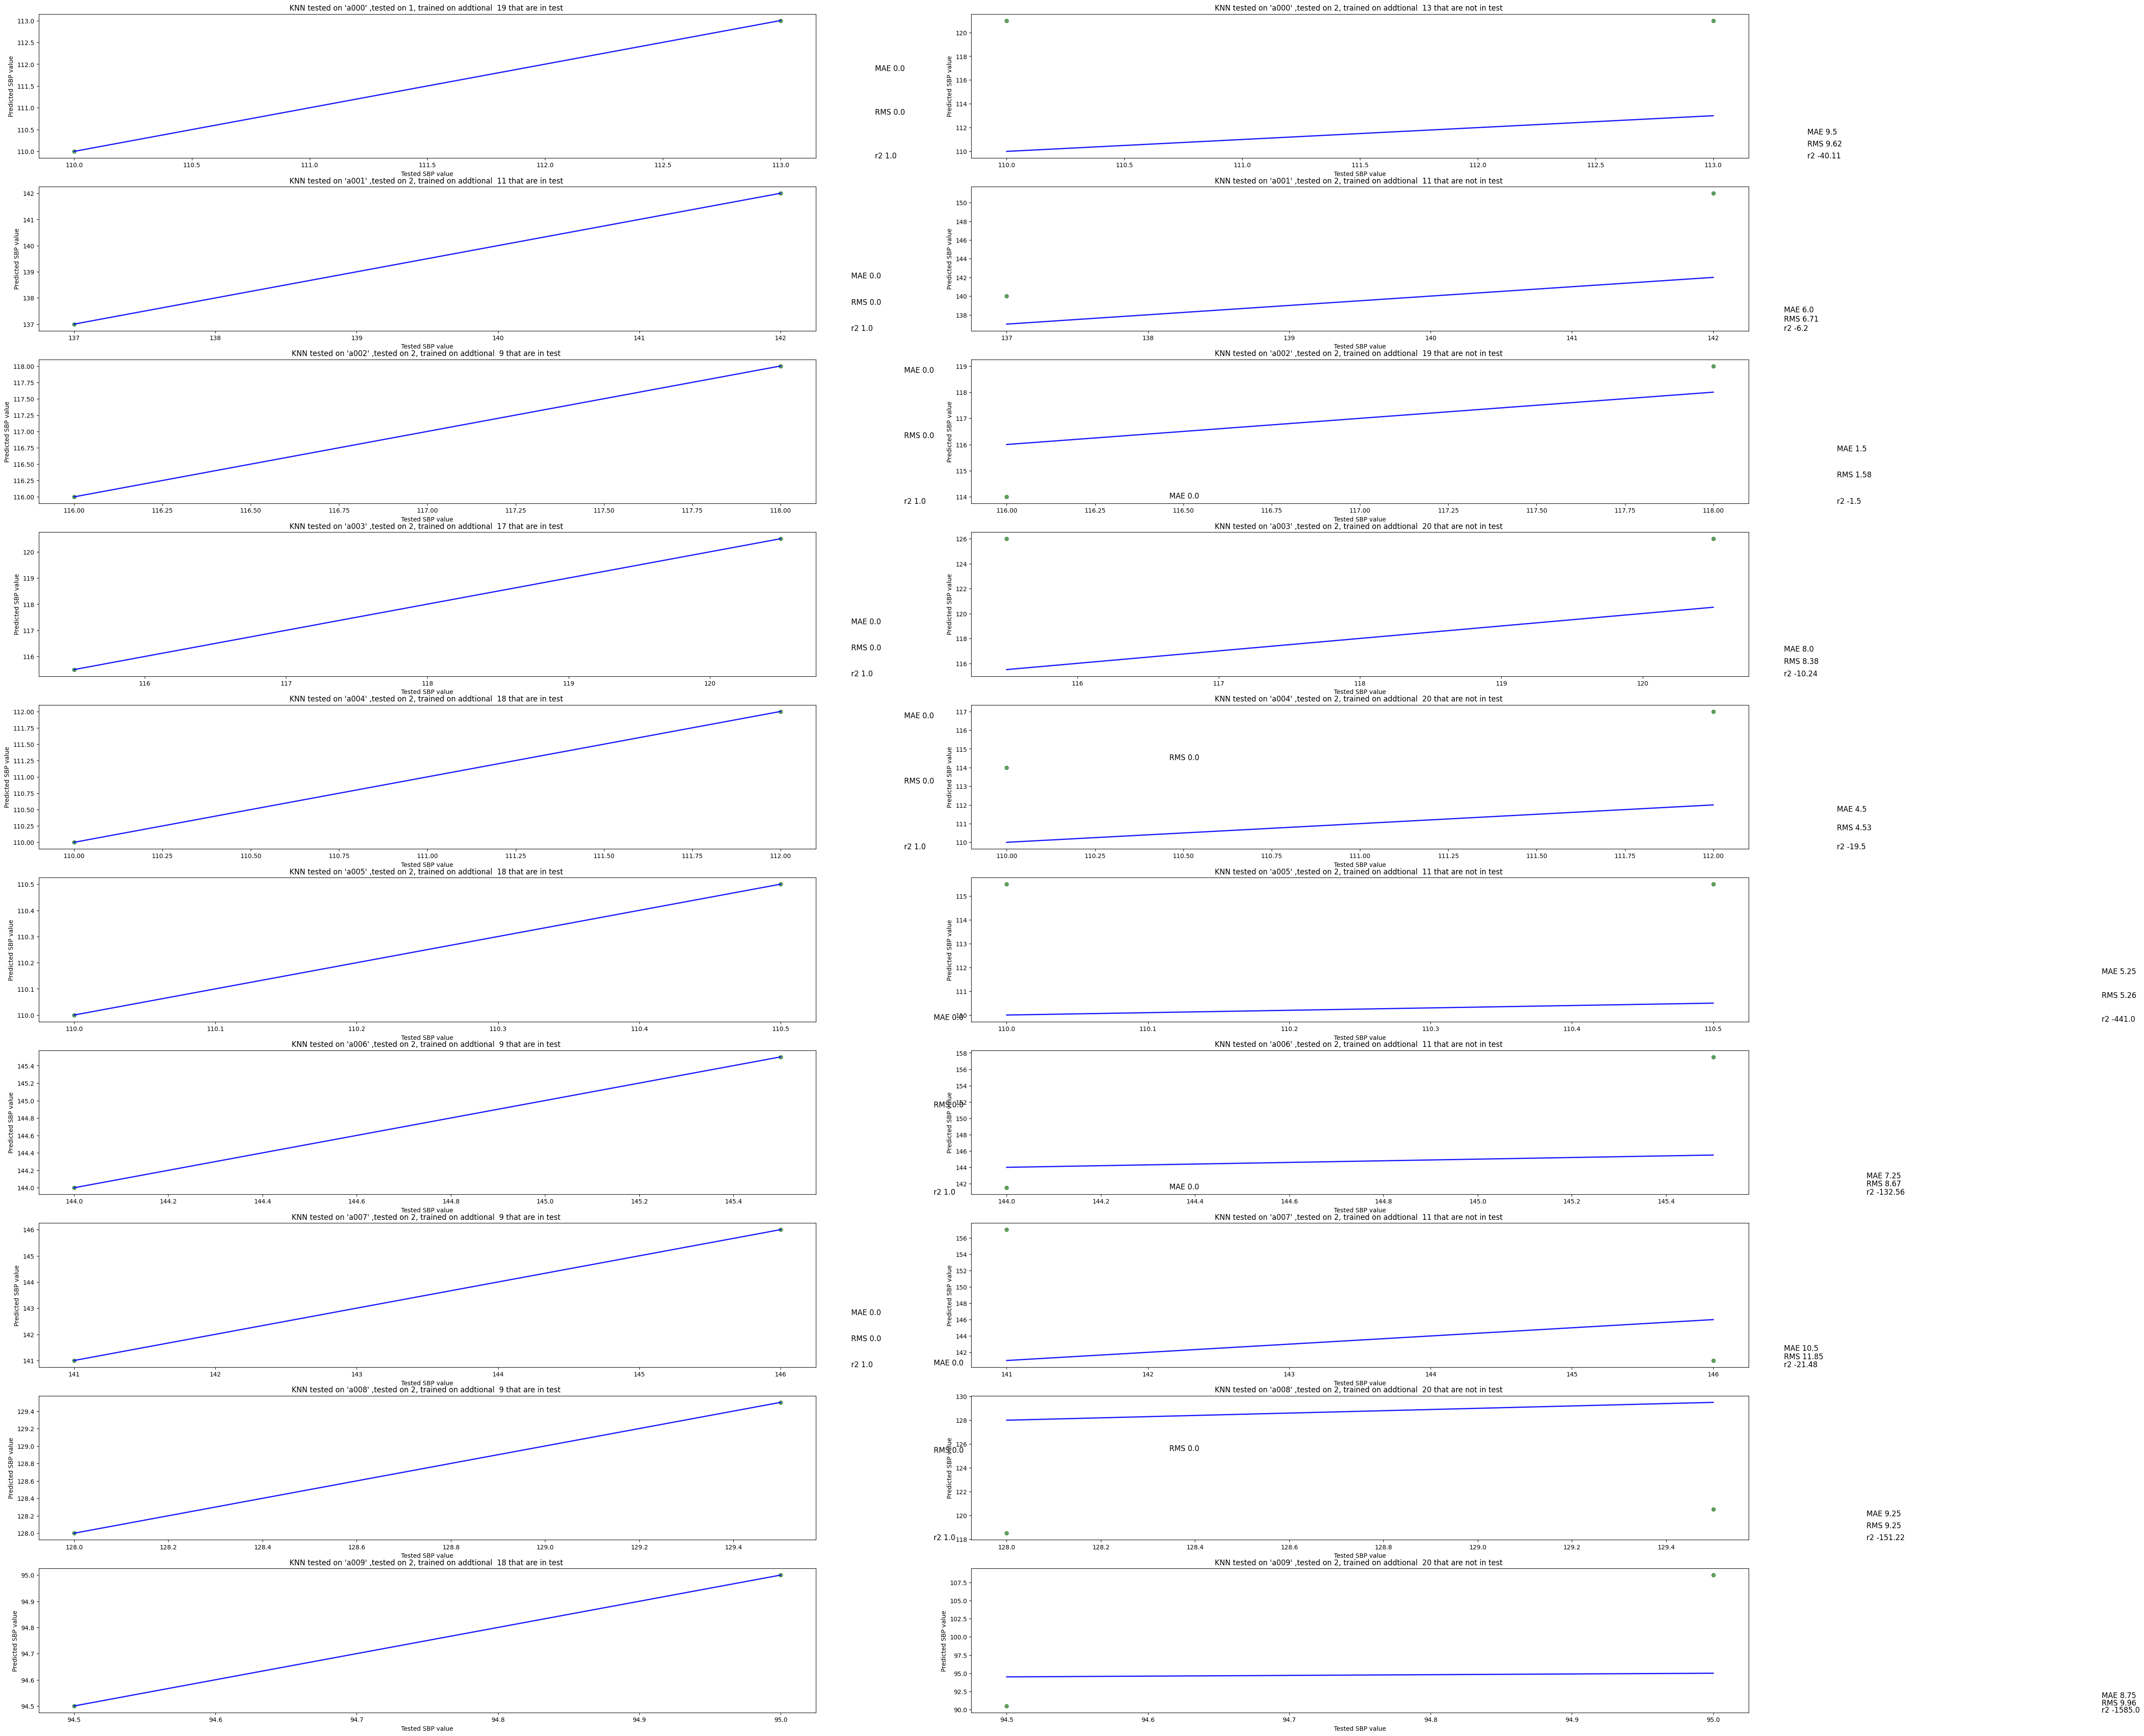

In [1526]:
plt.figure(figsize=(50, 50)) 
plt.rcParams['figure.figsize'] = [30, 30]

count=1
test_start = 2

for i in range(0,20):
    plt.subplot(10,2,count)  
    tester_pid = "a00"+str(i//2)
    neigh = KNeighborsRegressor(n_neighbors=1)
    X = get_person_data(tester_pid)[0]
    Y = get_person_data(tester_pid)[1]
    
    if i%2!=0:
        plt.title(f"KNN tested on '{tester_pid}' ,tested on {len(Y_test)}, trained on addtional  {len(Y_train)} that are not in test ")
        test_start = 2
        # X_test= np.array(X[:test_start])
        # Y_test= np.array(Y[:test_start])
    else:
        plt.title(f"KNN tested on '{tester_pid}' ,tested on {len(Y_test)}, trained on addtional  {len(Y_train)} that are in test ")
        test_start = 0
    X_test= np.array(X[:2])
    Y_test= np.array(Y[:2])

    X_test = X_test.reshape(X_test.shape[0], -1)
    Y_test = Y_test.reshape(Y_test.shape[0], -1)

    

    
    X_train =  np.array(X[test_start:])
    X_train = X_train.reshape(X_train.shape[0], -1)
    Y_train= Y[test_start:]

    
    
    

    #print(len(X_train), len(X_test), len(Y_train), len(Y_test))
    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    
    
    plt.scatter(Y_test, y_predict,  color="darkgreen",  alpha=0.6 )
    
    plt.plot(Y_test, Y_test, color="blue", linewidth=2, alpha=0.9)


    plt.xlabel("Tested SBP value")
    plt.ylabel("Predicted SBP value")
    xmin, xmax, ymin, ymax = plt.axis()

    #print(xmin, xmax, ymin, ymax)
    plt.text(xmax+0.25, ymin+2,s=f"MAE {mean_absolute_error(Y_test, y_predict)}", fontsize=12)
    plt.text(xmax+0.25, ymin+1, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    

    count+=1


hi  0.09646383738969111
mean abs error 16.451860226386092
RMS 21.562003082625953
r2  0.08649562521579479
y_predict mean 129.29240233162932


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


Text(309.325, 65.425, 'r2 0.09')

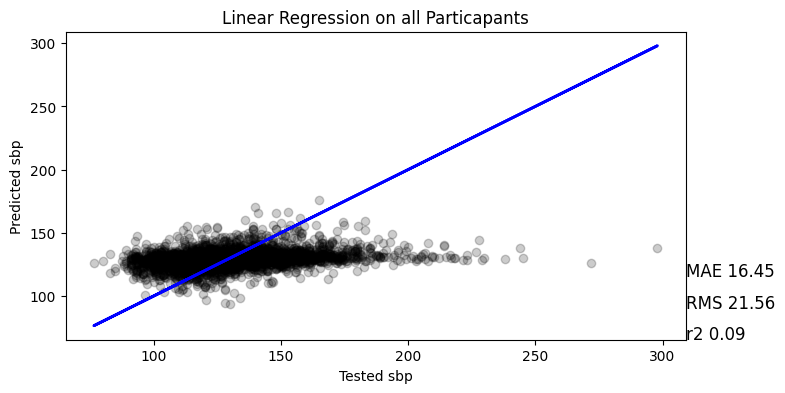

In [1628]:
# auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()][:1000]
# auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()][:1000]

# auscultatory_pressure= auscultatory_pressure[:100]
# auscultatory_sbp = auscultatory_sbp[:100]

plt.figure(figsize=(8, 4)) 

all_points = np.array(auscultatory_pressure)
all_points = all_points.reshape(all_points.shape[0], -1)




X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_sbp, test_size=0.3)
# X_train = all_points
# Y_train = auscultatory_sbp
model = LinearRegression()


the_fit= model.fit(X_train, Y_train)
score  = model.score(all_points, auscultatory_sbp)
print("hi ",score)
y_predict = model.predict(X_test)


# for i in range(len(y_predict)):
#     plt.vlines(x = Y_test[i], ymin =y_predict[i] , ymax = Y_test[i], alpha=0.1)


rms = root_mean_squared_error(Y_test, Y_test)
print("mean abs error",mean_absolute_error(Y_test, y_predict))
print("RMS",root_mean_squared_error(Y_test, y_predict))
print("r2 ",r2_score(Y_test, y_predict))

plt.rcParams.update({'font.size': 10})
#plt.legend(loc=(1.04, 0),fontsize=20)

plt.scatter(Y_test, y_predict,  color="black",  alpha=0.2 )
plt.plot(Y_test, Y_test, color="blue", linewidth=2)

plt.title(f"Linear Regression on all Particapants")

plt.xlabel("Tested sbp")
plt.ylabel("Predicted sbp")

print("y_predict mean",  np.mean(y_predict))
xmin, xmax, ymin, ymax = plt.axis()

#print(xmin, xmax, ymin, ymax)
plt.text(xmax+0.25, ymin+50,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
plt.text(xmax+0.25, ymin+25, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)

In [1337]:
# basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

In [1338]:
participants_csv_data = pd.read_csv(participants_data,sep = '\t')


#participants_csv_data = participants_csv_data[participants_csv_data["self_report_htn"]=="unmanaged"]

participants_csv_data = participants_csv_data[participants_csv_data["self_report_htn"].isin(["managed","unmanaged"])]
participants_csv_data = participants_csv_data[participants_csv_data["pid"].str.contains('a')]
people_htn = participants_csv_data["pid"]


In [1339]:
basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


Text(246.225, 67.925, 'r2 -0.27')

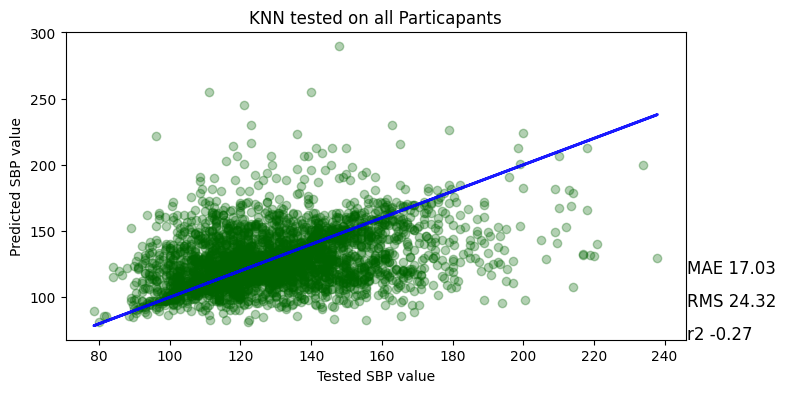

In [1629]:
# single ones
plt.figure(figsize=(8, 4)) 

neigh = KNeighborsRegressor(n_neighbors=1)


all_points = np.array(auscultatory_pressure)
all_points = all_points.reshape(all_points.shape[0], -1)
# auscultatory_sbp = np.array(auscultatory_sbp)
# auscultatory_sbp=auscultatory_sbp.reshape(1,-1) 
X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_sbp, test_size=0.3)
# X_train = all_points
# Y_train = auscultatory_sbp

tester_pid = "a000"

X_test = X_test.reshape(X_test.shape[0], -1)
# Y_test = Y_test.reshape(Y_test.shape[0], -1)


the_fit= neigh.fit(X_train, Y_train)

y_predict= neigh.predict(X_test)#, auscultatory_sbp[10])

# for i in range(len(y_predict)):

#     plt.vlines(x = Y_test[i], ymin =y_predict[i] , ymax = Y_test[i], alpha=0.3)

# rms = root_mean_squared_error(Y_test, Y_test)
# print("mean abs error",mean_absolute_error(Y_test, y_predict))
# print("RMS",root_mean_squared_error(Y_test, y_predict))
# print("r2 ",r2_score(Y_test, y_predict))
plt.rcParams.update({'font.size': 10})
#plt.legend(loc=(1.04, 0),fontsize=20)

plt.scatter(Y_test, y_predict,  color="darkgreen",  alpha=0.3 )
plt.plot(Y_test, Y_test, color="blue", linewidth=2, alpha=0.9)

plt.title(f"KNN tested on all Particapants")

plt.xlabel("Tested SBP value")
plt.ylabel("Predicted SBP value")

xmin, xmax, ymin, ymax = plt.axis()

#print(xmin, xmax, ymin, ymax)
plt.text(xmax+0.25, ymin+50,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
plt.text(xmax+0.25, ymin+25, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)


[array([[10.5]]), array([[5.5]]), array([[-3.5]]), array([[-9.5]]), array([[-9.]]), array([[0.5]]), array([[3.]]), array([[0.]]), array([[0.]]), array([[-4.]]), array([[-10.]]), array([[24.]]), array([[7.5]]), array([[3.5]]), array([[-7.5]]), array([[7.]]), array([[2.]]), array([[-2.]]), array([[-3.5]]), array([[-4.5]]), array([[-8.]]), array([[-5.]]), array([[0.]]), array([[0.]]), array([[4.]]), array([[-7.]]), array([[0.]]), array([[-4.5]]), array([[-5.5]]), array([[-1.]]), array([[2.5]]), array([[-9.5]]), array([[-4.5]]), array([[3.]]), array([[4.]]), array([[6.]]), array([[-22.]]), array([[0.5]]), array([[-0.5]]), array([[0.]]), array([[-12.]]), array([[12.]]), array([[-3.]]), array([[3.]]), array([[-4.]]), array([[24.]]), array([[4.]]), array([[-4.]]), array([[6.5]]), array([[-6.5]]), array([[1.5]]), array([[5.5]]), array([[7.5]]), array([[4.5]]), array([[4.]]), array([[-4.5]]), array([[4.5]]), array([[1.]]), array([[-4.5]]), array([[-1.]]), array([[0.]]), array([[0.]]), array([[9

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_37100/1199763844.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(i,abs(get_stats(values[1])[3]),'ro', color= "black")


<Figure size 3000x3000 with 0 Axes>

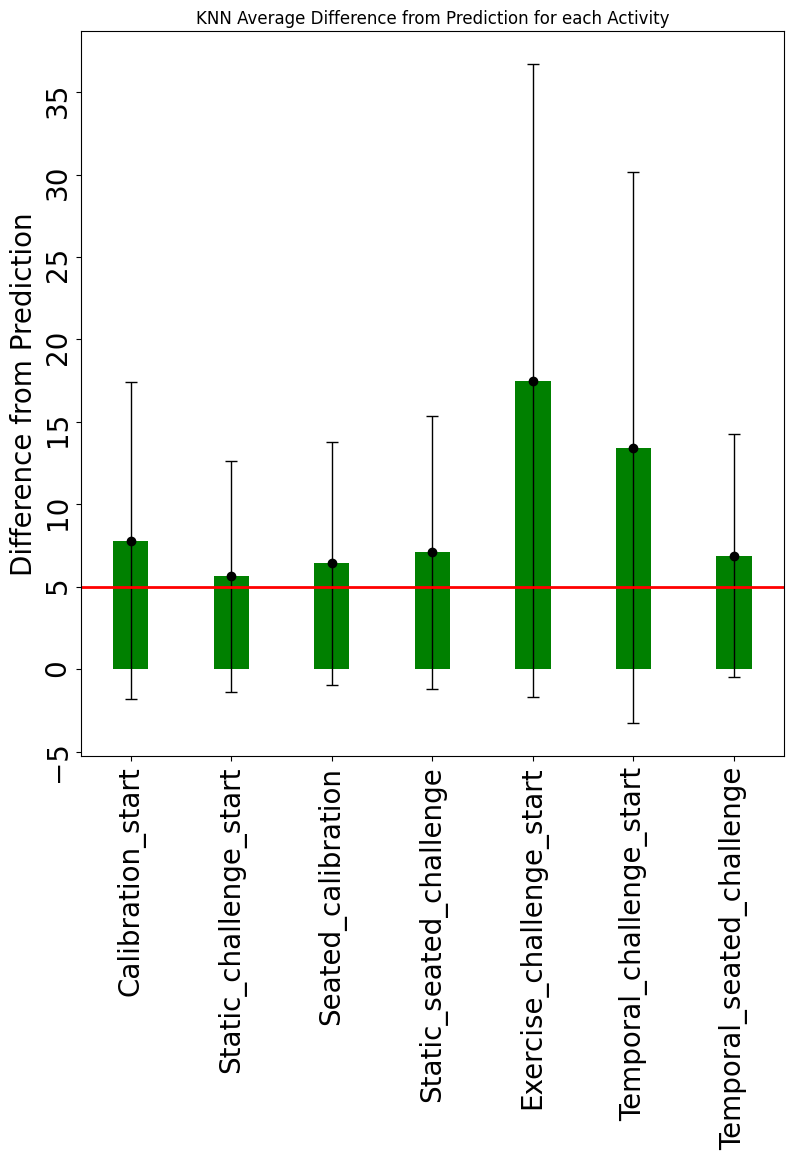

In [1686]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

group_activity = {}
for i in keys_for_grouping:
    group_activity[i] = [[],[]]


neigh = KNeighborsRegressor(n_neighbors=1)

test_start = 0



for person_key_id in list(group_ppl.keys())[:]:
    tester_pid = person_key_id
    
    X = get_person_data(tester_pid)[0]
    Y = get_person_data(tester_pid)[1]
    group_activity_keys = get_person_data(tester_pid)[2]
    for test_start in range(len(X)):
        
        X = get_person_data(tester_pid)[0]
        Y = get_person_data(tester_pid)[1]
        X_test= np.array(X[test_start])
        Y_test= np.array(Y[test_start])

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)




        X_train =  np.array(X[0:test_start]+X[test_start+1:])
        Y_train= Y[0:test_start] +Y[test_start+1:] 

        #print( len(Y[0:test_start]))

        X_train = X_train.reshape(X_train.shape[0], -1)


        the_fit= neigh.fit(X_train, Y_train)

        y_predict= neigh.predict(X_test)
        #print(abs(Y_test- y_predict),MAE, group_activity_keys[test_start])

        for i in keys_for_grouping:
            #print(type(group_activity_keys[test_start]))
            if i in str(group_activity_keys[test_start]):
                group_activity[i][0].append(y_predict- Y_test)
                group_activity[i][1].append(MAE)

        MAE = round(root_mean_squared_error(Y_test, y_predict),2,)





fig = plt.figure()
plt.figure(figsize=(8, 12)) 


for i,values in  group_activity.items():
    print(values[0])
    print(values[1
                 ])
    #plt.scatter(values[0],values[1],  alpha=0.5 , s=500, label=i)
    plt.bar(i, height=get_stats(values[1])[3], width=0.35,  align='center', color = "green", label=i)
    print(np.std(values[1]))
    plt.plot(i,abs(get_stats(values[1])[3]),'ro', color= "black")
    plt.errorbar(i,get_stats(values[1])[3]  , yerr=np.std(values[1]), capsize=4, ecolor='black', fmt=' ', elinewidth=1,)


#plt.set_xticks(list(group_activity.keys()))
num_values = np.arange(len(group_activity.keys()))
plt.rcParams.update({'font.size': 20})

#plt.legend(loc="upper left")

# ax.axhline(130, color="black", linewidth = 2)
# ax.axhline(90, color="gray", linewidth = 2)

plt.tick_params(rotation=90)

plt.axhline(5, color="red", linewidth = 2)

plt.title(f"KNN Average Difference from Prediction for each Activity")
#plt.figure(figsize=(100, 100)) 
plt.tight_layout()
plt.ylabel("Difference from Prediction")
plt.show()


[np.float64(16.077596286548072), np.float64(17.53718815796674), np.float64(5.605755672396796), np.float64(24.34557014148571), np.float64(20.12224838828311), np.float64(12.453644327815368), np.float64(2.311744233160212), np.float64(0.5366197012804435), np.float64(2.16842267281217), np.float64(15.967313183747322), np.float64(12.716653622490071), np.float64(18.42686587767335), np.float64(10.10756982317011), np.float64(3.162404384182736), np.float64(0.7751938240025567), np.float64(10.188003974705396), np.float64(10.359825154707934), np.float64(2.688037920038326), np.float64(48.417583307256166), np.float64(26.140019683873135), np.float64(96.76713258078354), np.float64(5.578915046359654), np.float64(1.1010323875112817), np.float64(1.6144853488313515), np.float64(20.397384400154436), np.float64(1.1400591306742172), np.float64(3.076563385815035), np.float64(29.953441697365037), np.float64(14.25069263567471), np.float64(14.227898481041422), np.float64(12.409631346943087), np.float64(1.585626396

/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_37100/3412539934.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(i,abs(get_stats(values[1])[3]),'ro', color= "black")


<Figure size 3000x3000 with 0 Axes>

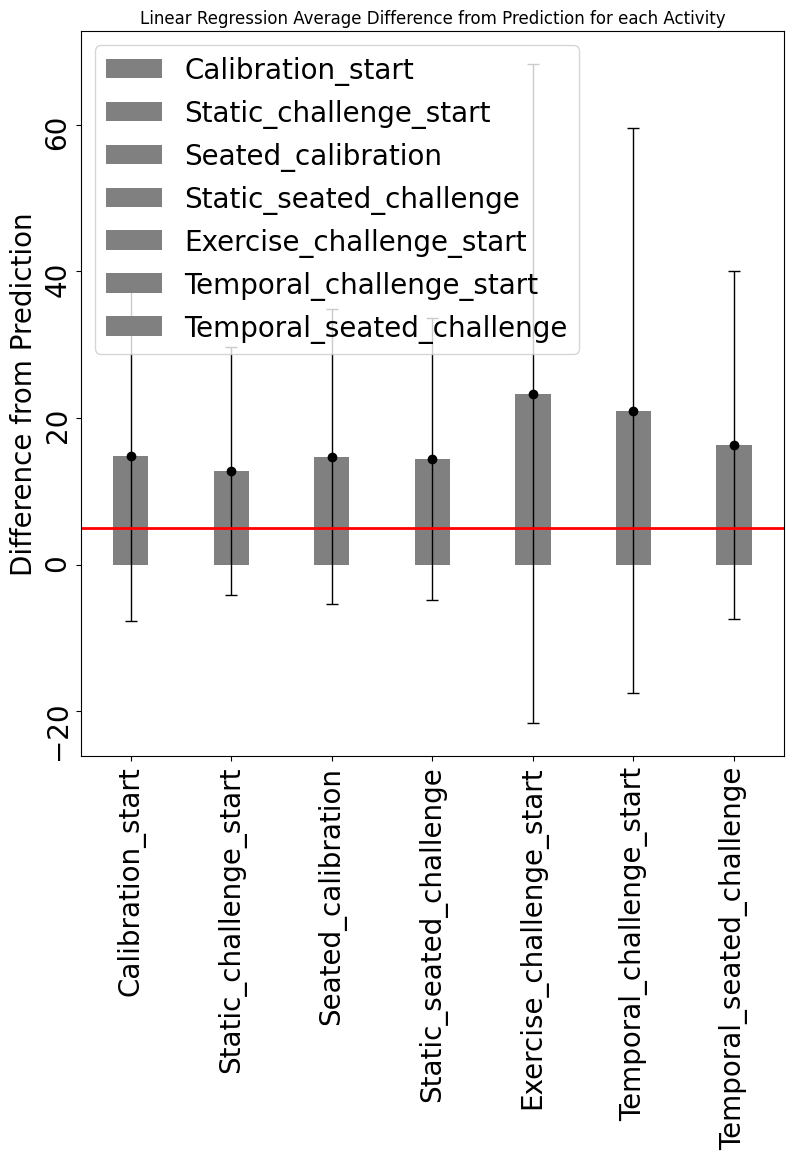

In [1682]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

group_activity = {}
for i in keys_for_grouping:
    group_activity[i] = [[],[]]


neigh = LinearRegression()

test_start = 0



for person_key_id in list(group_ppl.keys())[:]:
    tester_pid = person_key_id
    
    X = get_person_data(tester_pid)[0]
    Y = get_person_data(tester_pid)[1]
    group_activity_keys = get_person_data(tester_pid)[2]
    for test_start in range(len(X)):
        
        X = get_person_data(tester_pid)[0]
        Y = get_person_data(tester_pid)[1]
        X_test= np.array(X[test_start])
        Y_test= np.array(Y[test_start])

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)




        X_train =  np.array(X[0:test_start]+X[test_start+1:])
        Y_train= Y[0:test_start] +Y[test_start+1:] 

        #print( len(Y[0:test_start]))

        X_train = X_train.reshape(X_train.shape[0], -1)


        the_fit= neigh.fit(X_train, Y_train)

        y_predict= neigh.predict(X_test)
        #print(abs(Y_test- y_predict),MAE, group_activity_keys[test_start])

        for i in keys_for_grouping:
            #print(type(group_activity_keys[test_start]))
            if i in str(group_activity_keys[test_start]):
                group_activity[i][0].append(abs(Y_test- y_predict)[0][0])
                group_activity[i][1].append(MAE)

        MAE = round(root_mean_squared_error(Y_test, y_predict),2,)





fig = plt.figure()
plt.figure(figsize=(8, 12)) 


for i,values in  group_activity.items():
    print(values[0])
    print(values[1
                 ])
    #plt.scatter(values[0],values[1],  alpha=0.5 , s=500, label=i)
    plt.bar(i, height=get_stats(values[1])[3], width=0.35,  align='center', color = "grey", label=i)
    print(np.std(values[1]))
    plt.plot(i,abs(get_stats(values[1])[3]),'ro', color= "black")
    plt.errorbar(i,get_stats(values[1])[3]  , yerr=np.std(values[1]), capsize=4, ecolor='black', fmt=' ', elinewidth=1,)


#plt.set_xticks(list(group_activity.keys()))
num_values = np.arange(len(group_activity.keys()))
plt.rcParams.update({'font.size': 20})

plt.legend(loc="upper left")

# ax.axhline(130, color="black", linewidth = 2)
plt.axhline(5, color="red", linewidth = 2)

plt.tick_params(rotation=90)


plt.title(f"Linear Regression Average Difference from Prediction for each Activity")
#plt.figure(figsize=(100, 100)) 
plt.tight_layout()
plt.ylabel("Difference from Prediction")
plt.show()
